## Task: Image Inpainting Using Autoencoders

In this homework, you will perform **image inpainting（修复）** using **autoencoders**.

**Image inpainting** is the task of reconstructing missing or corrupted parts of an image. Given an incomplete or damaged image as input, the model should learn to produce a visually complete and realistic output.

We will use the **CIFAR-10** dataset for this task. Code is provided below to help you generate randomly corrupted versions of the images.

### Your objectives:

1. Construct and train an autoencoder model for image inpainting on the CIFAR-10 dataset.
2. As part of the evaluation, select and display **10 random examples** from the test set, showing both the corrupted input and the model's reconstructed output.

> 💡 **Hint:** Using a U-Net-like architecture may improve performance.


# 1. Import All Needed Libraries

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
from torch.utils.data import DataLoader


# 2. data preprocessing and make dataloader

In [ ]:
# --- 数据集定义 ---
# 作业中提供的 Dataset 类，我们直接使用。
# 它会加载 CIFAR-10 图像，并随机添加线条来“损坏”它们。
class Dataset(torchvision.datasets.CIFAR10):
  def __init__(self, path, image_dims=(32, 32), n_channels=3, train=True):
    # 调用父类的构造函数，如果数据集不存在，会自动下载
    super().__init__(path, train, download=True)
    self.image_dims = image_dims
    self.n_channels = n_channels
    # 定义一些图像变换操作
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    # __getitem__ 定义了当我们用索引访问数据集时（例如 dataset[0]），应该返回什么
    image, label = super().__getitem__(index) # 获取原始图像和标签

    # Y_output 是我们的目标，即原始的、完整的图像
    Y_output = self.resize(image)
    # X_input 是我们的输入，即被随机线条损坏的图像
    X_input, X_mask = self.Create_Mask(Y_output)

    # 将所有图像都转换为 PyTorch 张量 (Tensor)
    # ToTensor() 会将图像的像素值从 [0, 255] 缩放到 [0.0, 1.0]
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    # 这个函数负责创建损坏图像
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype=np.uint8)
    # np.full 是 Python 中非常流行的科学计算库 NumPy 的一个函数，它的作用是创建一个指定形状和类型的数组，并用一个指定的常量值来填充整个数组。

    # 随机画 1 到 10 条线
    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(1, 3)
      # 用黑色(1,1,1)画线在白色的mask上
      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    # 使用位运算 "and" 将黑色线条区域应用到原始图像上，形成损坏图像
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask


In [32]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")
print(f"device now using: {device}")

Using MPS device for Apple Silicon GPU acceleration.
device now using: mps


In [33]:
Trainset = Dataset('./data')
Testset = Dataset('./data', train=False)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
def show_imgs(masked_image, mask, original_image):
  f, axs = plt.subplots(1,3)
  axs[0].imshow(np.transpose(masked_image.numpy(), (1,2,0)))
  axs[0].set_title("Masked Image")
  axs[1].imshow(np.transpose(mask.numpy(), (1,2,0)))
  axs[1].set_title("Mask")
  axs[2].imshow(np.transpose(original_image.numpy(), (1,2,0)))
  axs[2].set_title("Original Image")

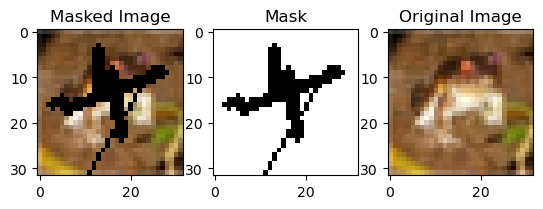

In [35]:
show_imgs(*Trainset[0])

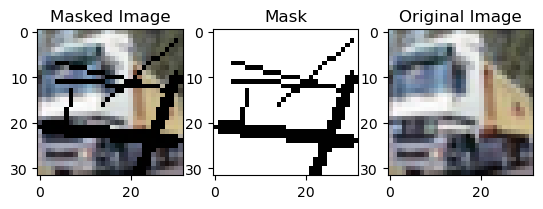

In [36]:
show_imgs(*Trainset[1])

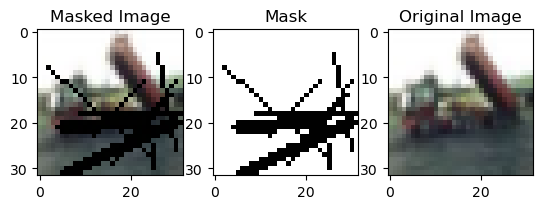

In [37]:
show_imgs(*Trainset[2])

In [38]:
# 定义超参数
batch_size = 128 # 每次训练迭代中使用的样本数量
learning_rate = 0.001 # 学习率，控制模型参数更新的步长
epochs = 100 # 训练的总轮数

# 创建数据加载器 (DataLoader)
# DataLoader 会自动地将数据整理成批次(batch)，并在每个 epoch 开始时打乱数据
Trainloader = DataLoader(Trainset, batch_size=batch_size, shuffle=True, num_workers=0)
Testloader = DataLoader(Testset, batch_size=batch_size, shuffle=False, num_workers=0)

# *3. Construct AE Using U-Net

Firstly, we need to know what a *U-Net* architecture is.

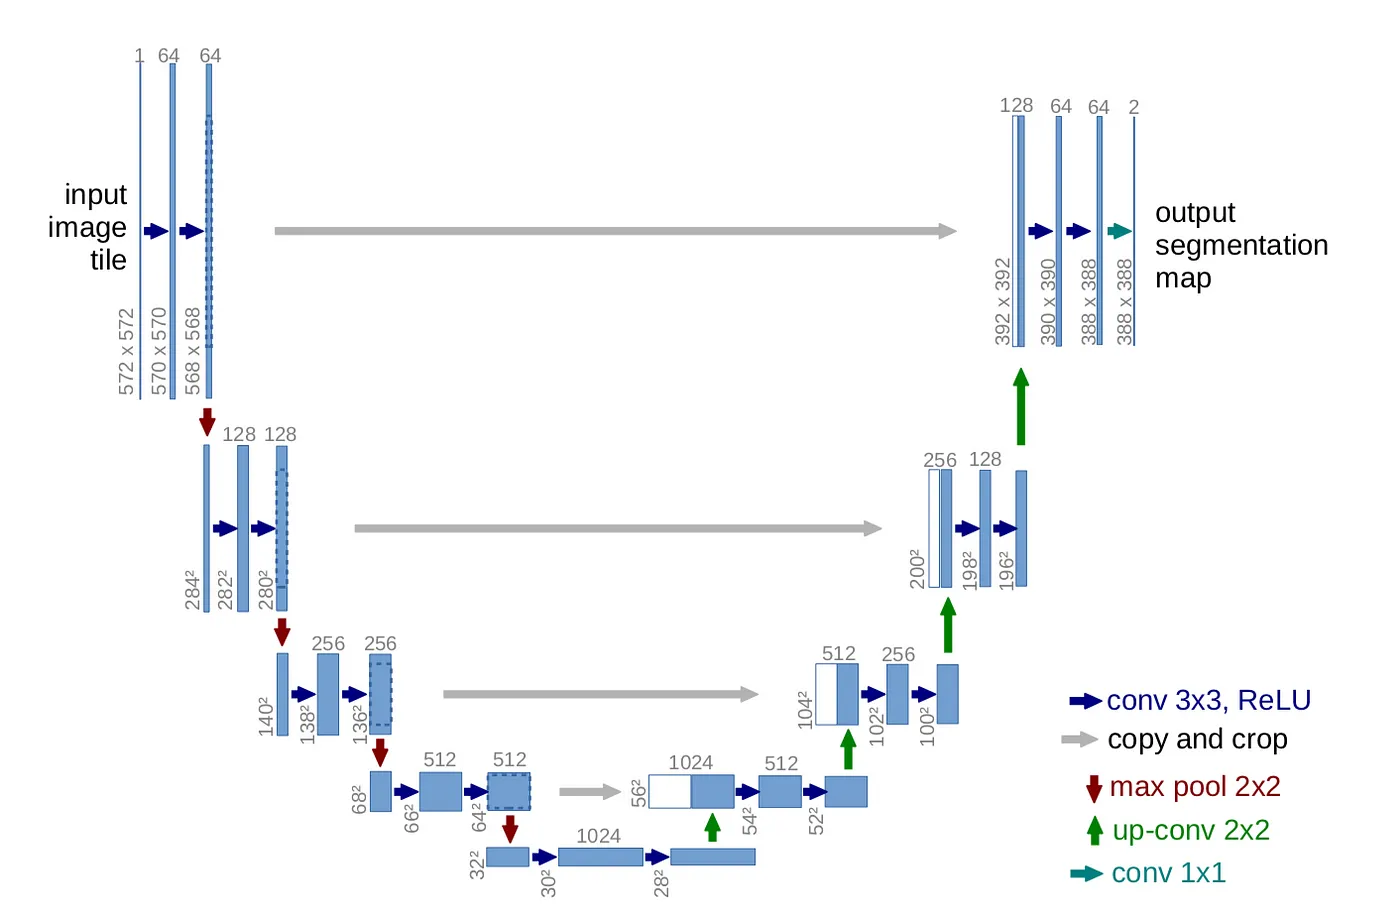

The creation of the U-Net was a ground breaking discovery in the realm of image segmentation, a field focused on locating objects and boundaries within an image. This novel architecture proved to carry immense value in the analysis of biomedical images.

The U-Net is composed of two main components: a contracting path and an expanding path.

* Contracting path: aims to decrease the spatial dimensions of the image, while also capturing relevant information about the image.

* Expanding path: aims to upsample the feature map and produce a relevant segmentation map using the patterns learnt in the contracting path.

**Up-Convolution**

An up-convolution, also known as a deconvolution or transpose convolution, is a method used to upsample images and recover spatial information.

Let’s look at the example below and briefly discuss what’s happening.

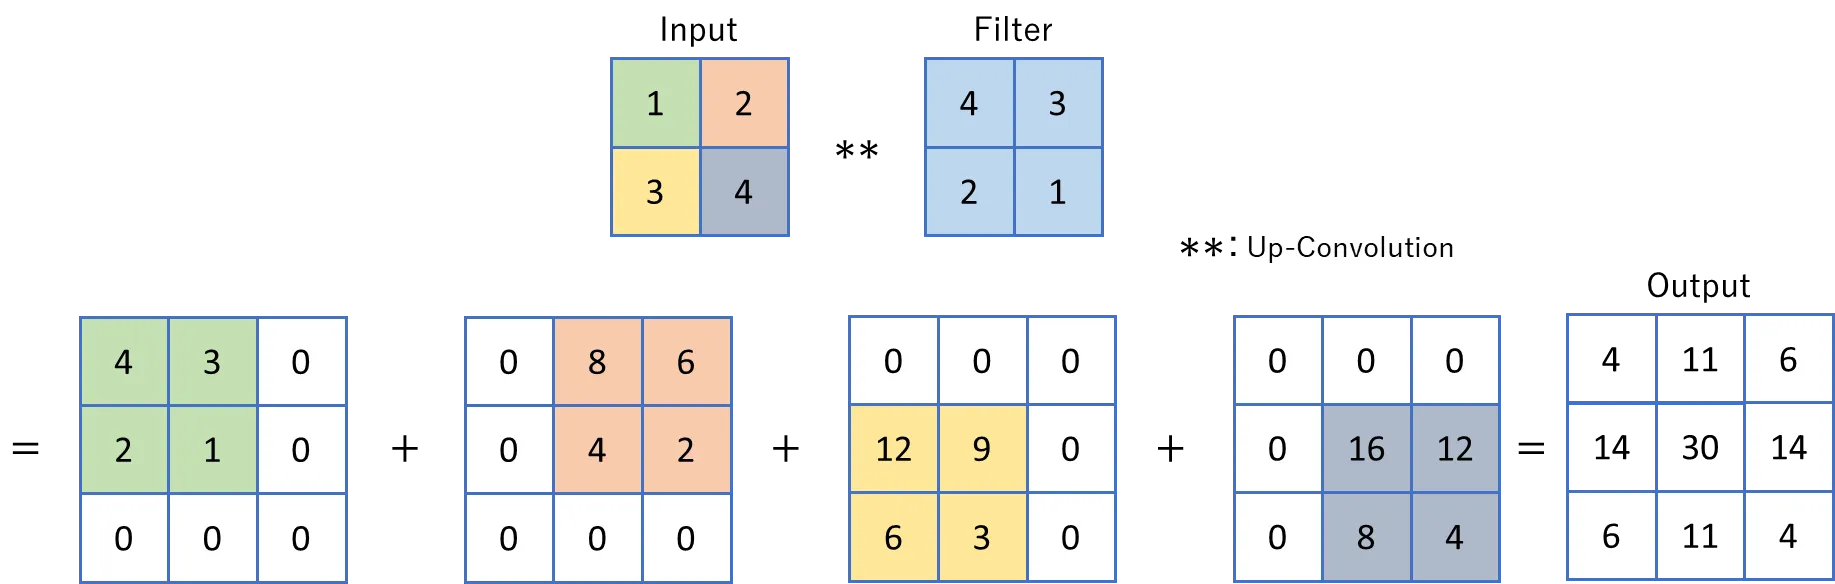

The best way to perform up-convolutions is to expand and duplicate each element from the input feature map to the same size as the filter. This process up-samples the input. The filter is then applied over each of these expanded regions.

## Contracting Path
The contracting path uses a combination of convolution and pooling layers to extract and capture features within an image, while at the same time, reducing its spatial dimensions.

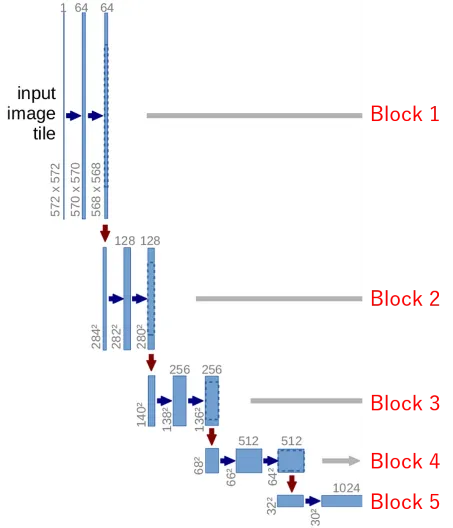

### Block 1
1. An input image with dimensions 572² is fed into the U-Net. This input image consists of only 1 channel, likely a grayscale channel.
2. Two 3x3 convolution layers (unpadded) are then applied to the input image, each followed by a ReLU layer. At the same time the number of channels are increased to 64 in order to capture higher level features.
3. A 2x2 max pooling layer with a stride of 2 is then applied. This downsamples the feature map to half its size, 284².

### Block 2
1. Just like in block 1, two 3x3 convolution layers (unpadded) are applied to the output of block 1, each followed again by a ReLU layer. At each new block the number of feature channels are doubled, now to 128.
2. Next a 2x2 max pooling layer is again applied to the resulting feature map reducing the spatial dimensions by half to 140².

### Block 3
The procedure used in block 1 and 2 is the same as in block 3, so will not be repeated.

### Block 4
Same as block 3.

### Block 5
1. In the final block of the contracting path, the number of feature channels reach 1024 after being doubled at each block.
2. This block also contains two 3x3 convolution layers (unpadded), which are each followed by a ReLU layer. However, for symmetry purposes, I have only included one layer and included the second layer in the expanding path.
After complex features and patterns have been extracted, the feature map moves on to the expanding path.



## Expanding Path
The expanding path uses both convolution and up-convolution operations to combine learnt features and upsample the input feature map until it generates a segmentation map.

Much like with the contracting path, each block will be discussed below.

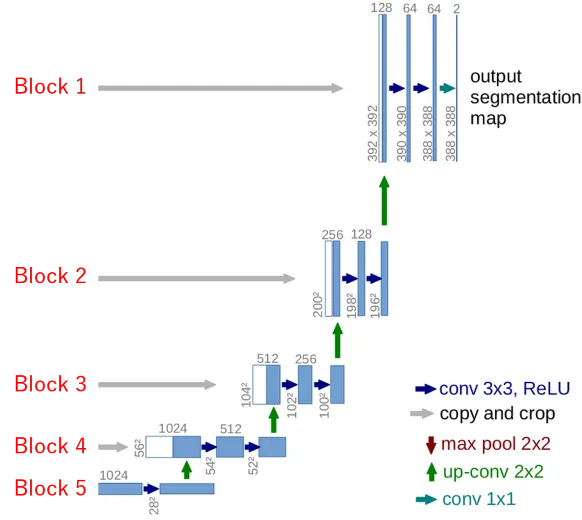

### Block 5
1. Continuing on from the contracting path, a second 3x3 convolution (unpadded) is applied with a ReLU layer after it.
2. Then a 2x2 convolution (up-convolution) layer is applied, upsampling the spatial dimensions twofold and also halving the number of channels to 512.

### Block 4
1. Using skip connections, the corresponding feature map from the contracting path is then concatenated, doubling the feature channels to 1024. Note that this concatenation must be cropped to match the expanding path’s dimensions.
2. Two 3x3 convolution layers (unpadded) are applied, each with a ReLU layer following, reducing the channels to 512.
3. After, a 2x2 convolution (up-convolution) layer is applied, upsampling the spatial dimensions twofold and also halving the number of channels to 256.

### Block 3
The procedure used in block 5 and 4 is the same as in block 3, so will not be repeated.

### Block 2
Same as block 3.

### Block 1
1. In the final block of the expanding path, there are 128 channels after concatenating the skip connection.
2. Next, two 3x3 convolution layers (unpadded) are applied on the feature map, with ReLU layers inbetween reducing the number of feature channels to 64.
3. Finally, a 1x1 convolution layer, followed by an activation layer (sigmoid for binary classification) is used to reduce the number of channels to the desired number of classes. In this case, 2 classes, as binary classification is often used in medical imaging.

After upsampling the feature map in the expanding path, a segmentation map should be generated, with each pixel classified individually.

**图中所有横向的灰色箭头（Skip Connection），都隐含了这个“裁切并复制”（Copy and Crop）的步骤。**

# 4.1 Model Training & Evaluation 1：Basic AE Model

In [39]:
# 这是一个经典的卷积自编码器结构
class Autoencoder_Simple(nn.Module):
    def __init__(self):
        super(Autoencoder_Simple, self).__init__()

        # --- 编码器 (Encoder) ---
        # 编码器的作用是“压缩”图像，提取其关键特征。
        # 它通过一系列卷积层逐步减小图像的空间维度（高度和宽度），同时增加通道数（特征维度）。
        self.encoder = nn.Sequential(
            # 输入: (N, 3, 32, 32) N代表batch_size, 3是RGB通道, 32x32是图像尺寸
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # -> (N, 16, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # -> (N, 16, 16, 16)
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # -> (N, 32, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # -> (N, 32, 8, 8)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # -> (N, 64, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # -> (N, 64, 4, 4) 这是“瓶颈层”，即压缩后的潜在表示
        )

        # --- 解码器 (Decoder) ---
        # 解码器的作用是“解压”，从压缩的潜在表示中重建出原始图像。
        # 它的结构通常与编码器对称，通过一系列“反卷积”层逐步恢复图像的空间维度。
        self.decoder = nn.Sequential(
            # 输入: (N, 64, 4, 4)
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), # -> (N, 32, 8, 8)
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), # -> (N, 16, 16, 16)
            nn.ReLU(),

            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2), # -> (N, 3, 32, 32)
            
            # 使用 Sigmoid 激活函数。因为输入图像的像素值被缩放到 [0, 1] 范围，
            # Sigmoid 的输出范围恰好也是 [0, 1]，非常适合用于重建图像。
            nn.Sigmoid()
        )

    def forward(self, x):
        # 定义数据在模型中的流动方式
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 实例化模型并将其移动到 GPU (如果可用)
model_simple = Autoencoder_Simple().to(device)
print(model_simple)

Autoencoder_Simple(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)


In [40]:
# 损失函数：衡量模型输出（重建图像）与目标（原始图像）之间的差距。
# 均方误差损失 (Mean Squared Error Loss) 是图像重建任务的常用选择。
criterion = nn.MSELoss()

# 优化器：根据损失函数计算出的梯度来更新模型的权重。
# Adam 是一种高效且常用的优化算法。
optimizer = optim.Adam(model_simple.parameters(), lr=learning_rate)

In [41]:
print("Training started for Model 1 (using simple AE) ...")
for epoch in range(epochs):
    running_loss = 0.0
    # 从训练数据加载器中迭代获取每一批数据
    for data in Trainloader:
        # data 是一个包含 (损坏图像, 掩码, 原始图像) 的元组
        masked_img, _, original_img = data
        
        # 将输入（损坏图像）和目标（原始图像）移动到指定设备
        masked_img = masked_img.to(device)
        original_img = original_img.to(device)

        # --- 前向传播 ---
        # 将损坏的图像输入模型，得到重建的图像
        outputs = model_simple(masked_img)
        # 计算损失
        loss = criterion(outputs, original_img)

        # --- 反向传播和优化 ---
        # 1. 清空之前的梯度
        optimizer.zero_grad()
        # 2. 计算梯度
        loss.backward()
        # 3. 更新模型权重
        optimizer.step()

        running_loss += loss.item()

    # 打印每个 epoch 的平均损失
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss / len(Trainloader):.6f}")

print("Training completed!")

Training started for Model 1 (using simple AE) ...
Epoch [1/100], Average Loss: 0.028073
Epoch [2/100], Average Loss: 0.015415
Epoch [3/100], Average Loss: 0.013703
Epoch [4/100], Average Loss: 0.012777
Epoch [5/100], Average Loss: 0.012167
Epoch [6/100], Average Loss: 0.011741
Epoch [7/100], Average Loss: 0.011359
Epoch [8/100], Average Loss: 0.011096
Epoch [9/100], Average Loss: 0.010870
Epoch [10/100], Average Loss: 0.010648
Epoch [11/100], Average Loss: 0.010449
Epoch [12/100], Average Loss: 0.010287
Epoch [13/100], Average Loss: 0.010070
Epoch [14/100], Average Loss: 0.009828
Epoch [15/100], Average Loss: 0.009631
Epoch [16/100], Average Loss: 0.009497
Epoch [17/100], Average Loss: 0.009366
Epoch [18/100], Average Loss: 0.009259
Epoch [19/100], Average Loss: 0.009174
Epoch [20/100], Average Loss: 0.009074
Epoch [21/100], Average Loss: 0.009005
Epoch [22/100], Average Loss: 0.008949
Epoch [23/100], Average Loss: 0.008890
Epoch [24/100], Average Loss: 0.008817
Epoch [25/100], Averag

Start evaluating the model and displaying reconstruction results...


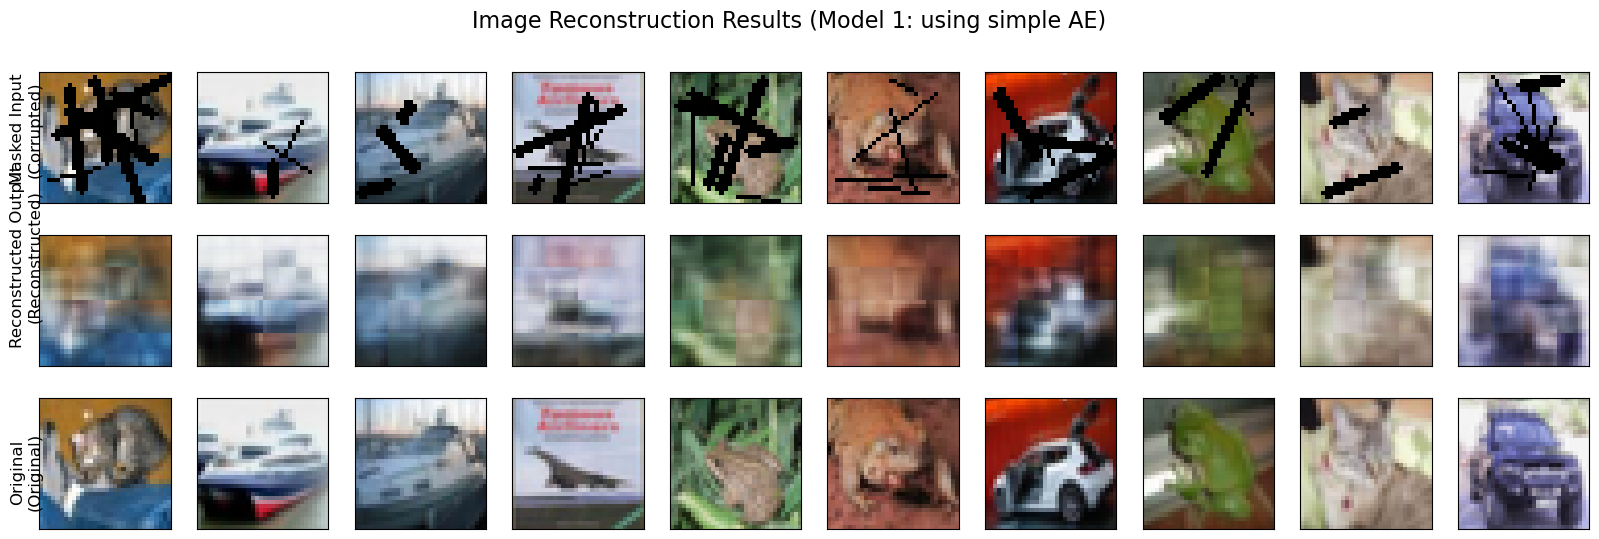

In [42]:
print("Start evaluating the model and displaying reconstruction results...")

# 将模型设置为评估模式。这会关闭 Dropout 和 BatchNorm 等层，在评估时很重要。
model_simple.eval()

# 从测试数据加载器中获取一个批次的数据用于展示
# 使用 with torch.no_grad() 来禁用梯度计算，可以节省计算资源
with torch.no_grad():
    # 获取一个批次
    data_iter = iter(Testloader)
    masked_test_imgs, _, original_test_imgs = next(data_iter)
    
    # 将测试图像输入模型进行修复
    reconstructed_imgs = model_simple(masked_test_imgs.to(device))
    
    # 将结果移回 CPU 以便用 matplotlib 显示
    masked_test_imgs = masked_test_imgs.cpu()
    reconstructed_imgs = reconstructed_imgs.cpu()
    original_test_imgs = original_test_imgs.cpu()

    # --- 可视化结果 ---
    n = 10 # 显示 10 个样本
    plt.figure(figsize=(20, 6))
    plt.suptitle("Image Reconstruction Results (Model 1: using simple AE)", fontsize=16)

    for i in range(n):
        # 显示损坏的输入图像
        ax = plt.subplot(3, n, i + 1)
        # np.transpose 将 (C, H, W) 转换为 (H, W, C) 以便显示
        plt.imshow(np.transpose(masked_test_imgs[i].numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Masked Input\n(Corrupted)", rotation=90, x=-0.1, y=0.1)

        # 显示模型重建的图像
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(np.transpose(reconstructed_imgs[i].numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Reconstructed Output\n(Reconstructed)", rotation=90, x=-0.1, y=0.1)
            
        # 显示原始的真实图像
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(np.transpose(original_test_imgs[i].numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original\n(Original)", rotation=90, x=-0.1, y=0.1)

    plt.show()

We can see that the simple AE model is not that good at generating these images.

# 4.2 Model Training & Evaluation 2：AE Model Using U-Net

In [43]:
# U-Net 模型的核心是编码器-解码器结构加上“跳层连接”。
class Autoencoder_UNet(nn.Module):
    def __init__(self):
        super(Autoencoder_UNet, self).__init__()

        # --- 编码器 (Contracting Path / 下采样路径) ---
        # 每一层的输出都会被保存下来，用于后续与解码器对应层进行连接。
        # 3x32x32
        self.enc_conv1 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), nn.ReLU()) # -> 32x32x32
        self.pool1 = nn.MaxPool2d(2, 2) # -> 32x16x16
        
        self.enc_conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU()) # -> 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2) # -> 64x8x8

        # --- 瓶颈层 (Bottleneck) ---
        self.bottleneck = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU()) # -> 128x8x8

        # --- 解码器 (Expanding Path / 上采样路径) ---
        # 在每个上采样步骤后，我们会将结果与编码器对应层的输出进行拼接 (concatenate)。
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2) # -> 64x16x16
        # 拼接后通道数会翻倍 (64+64=128)，所以下一层卷积的输入通道是 128
        self.dec_conv1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()) # -> 64x16x16

        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2) # -> 32x32x32
        # 拼接后通道数 (32+32=64)
        self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()) # -> 32x32x32
        
        # --- 输出层 ---
        # 最后一层卷积将通道数变回 3 (RGB)，然后用 Sigmoid 输出。
        self.out_conv = nn.Sequential(nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()) # -> 3x32x32

    def forward(self, x):
        # --- 编码过程 ---
        # 我们需要保存 e1 和 e2 的输出，用于跳层连接
        e1 = self.enc_conv1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        # 这里的变量 e1 和 e2 就扮演了“暂存盘”的角色，它们保存了包含高分辨率细节的原始特征。

        # --- 瓶颈 ---
        b = self.bottleneck(p2)

        # --- 解码过程与跳层连接 ---
        # 第一次上采样
        d1 = self.upconv1(b)
        # **核心操作**: 将上采样结果 d1 与编码器第二层的输出 e2 在通道维度上拼接
        # d1 shape: (N, 64, 16, 16), e2 shape: (N, 64, 16, 16)
        # cat_d1 shape: (N, 128, 16, 16)
        cat_d1 = torch.cat((d1, e2), dim=1) 
        d1_out = self.dec_conv1(cat_d1)

        # 第二次上采样
        d2 = self.upconv2(d1_out)
        # **核心操作**: 将上采样结果 d2 与编码器第一层的输出 e1 拼接
        # d2 shape: (N, 32, 32, 32), e1 shape: (N, 32, 32, 32)
        # cat_d2 shape: (N, 64, 32, 32)
        cat_d2 = torch.cat((d2, e1), dim=1)
        d2_out = self.dec_conv2(cat_d2)

        # --- 输出 ---
        output = self.out_conv(d2_out)
        
        return output

# 实例化模型并将其移动到 GPU (如果可用)
model_unet = Autoencoder_UNet().to(device)
print(model_unet)

Autoencoder_UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (upconv1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (dec_conv1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (upconv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec_conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (out_conv): Sequential(
    (0): Conv2d(32, 3, kern

![Screenshot 2025-07-03 at 12.32.04.png](<attachment:Screenshot 2025-07-03 at 12.32.04.png>)
![Screenshot 2025-07-03 at 12.32.11.png](<attachment:Screenshot 2025-07-03 at 12.32.11.png>)
![Screenshot 2025-07-03 at 12.32.25.png](<attachment:Screenshot 2025-07-03 at 12.32.25.png>)
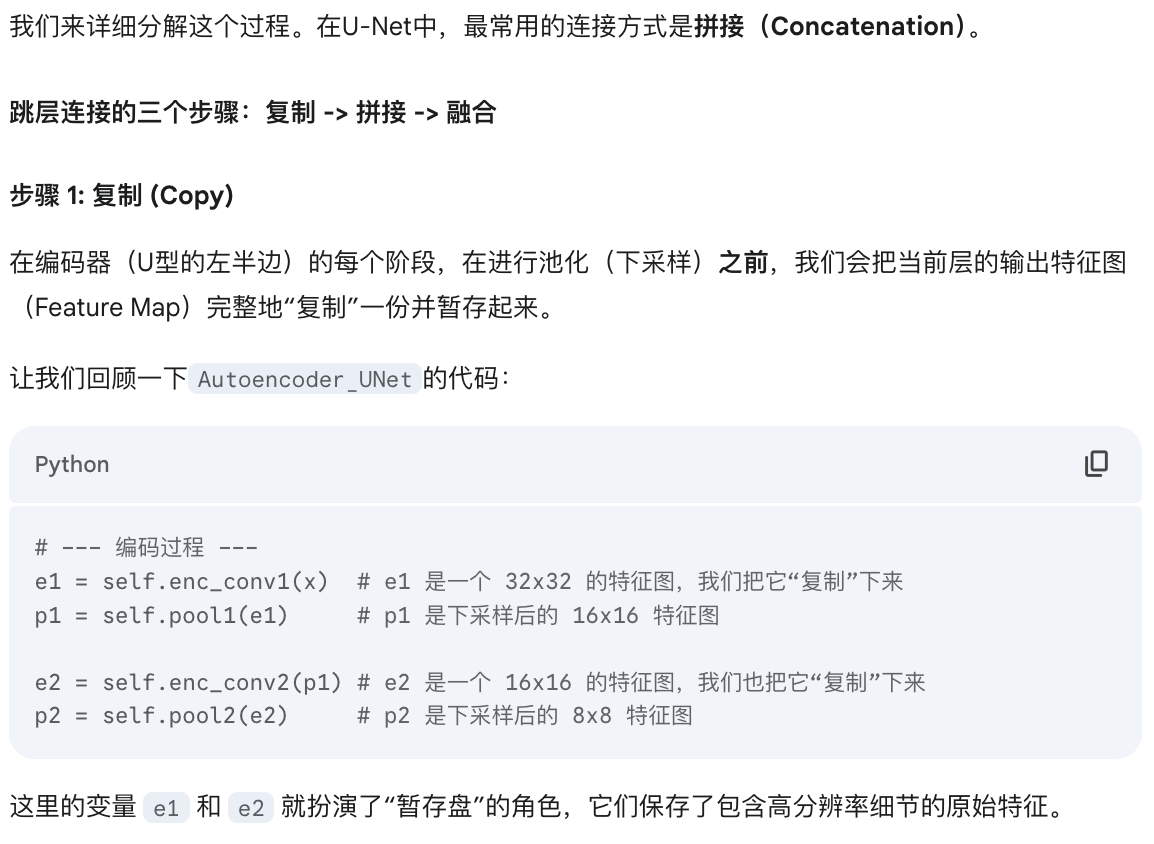
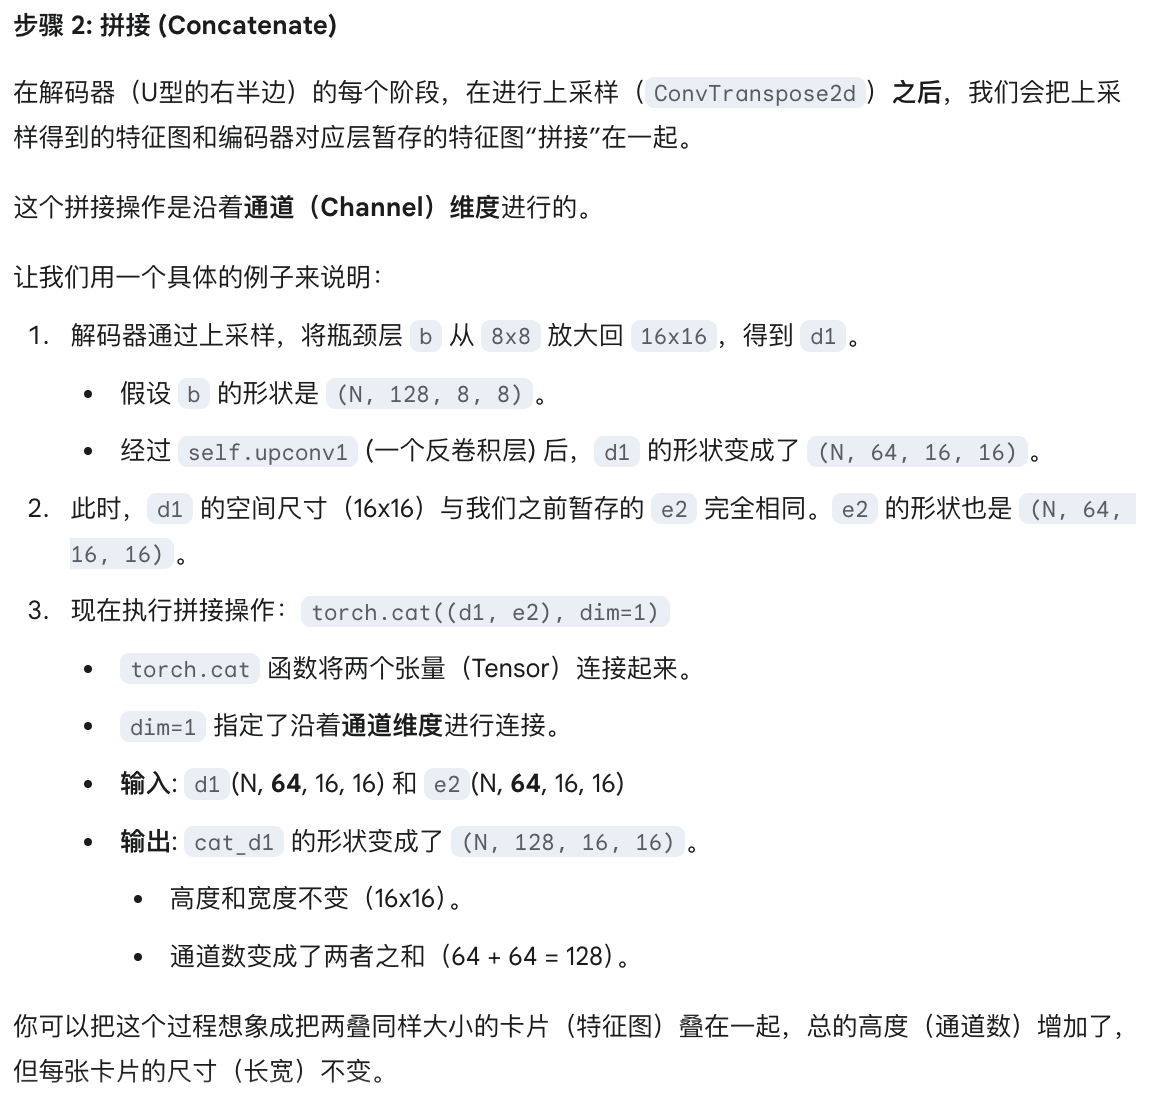
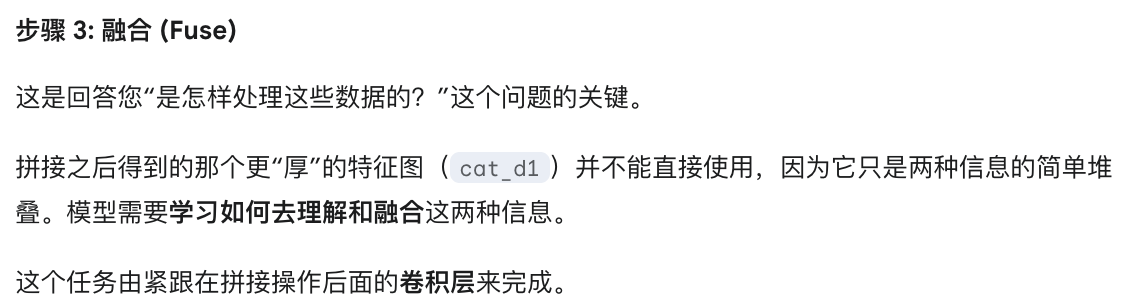

cat_d1 = torch.cat((d1, e2), dim=1) 

**下面这个卷积层就是“融合”的关键**

d1_out = self.dec_conv1(cat_d1) 

`self.dec_conv1` 是一个普通的 `Conv2d` 卷积层，它的输入通道数被特意设置成了 `128`，正好匹配拼接后的通道数。

这个卷积层的作用是：
* **接收**来自解码器深层的**高级语义信息**（`d1` 部分，它知道“这里应该是个眼睛”）。
* **接收**来自编码器浅层的**高分辨率细节信息**（`e2` 部分，它知道“眼睛的精确轮廓和边缘在哪里”）。
* 通过自身的权重（这些权重是在训练中学习到的），**智能地将这两种信息结合起来**，生成一个既包含正确语义又包含精确细节的、新的、更优的特征图（`d1_out`）。

**总结**

所以，跳层连接的完整流程是：

1.  **复制**：在编码器中保存高分辨率的特征图。
2.  **拼接**：在解码器中，将上采样后的特征图与保存的特征图沿着通道维度“堆叠”起来。
3.  **融合**：用一个或多个卷积层来处理这个拼接后的“加厚版”特征图，让模型学习如何最好地结合上下文信息和细节信息。

这个“复制-拼接-融合”的机制，就是U-Net能够生成如此清晰、精确结果的秘密武器。

In [44]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_unet.parameters(), lr=learning_rate)

In [45]:
print("Training startd for Model 2 (using U-Net) ...")
for epoch in range(epochs):
    running_loss = 0.0
    for data in Trainloader:
        masked_img, _, original_img = data
        masked_img = masked_img.to(device)
        original_img = original_img.to(device)

        outputs = model_unet(masked_img)
        loss = criterion(outputs, original_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Average Loss {running_loss / len(Trainloader):.6f}")

print("Traning completed for U-Net model!")

Training startd for Model 2 (using U-Net) ...
Epoch [1/100], Average Loss 0.008956
Epoch [2/100], Average Loss 0.002977
Epoch [3/100], Average Loss 0.002302
Epoch [4/100], Average Loss 0.002062
Epoch [5/100], Average Loss 0.001911
Epoch [6/100], Average Loss 0.001791
Epoch [7/100], Average Loss 0.001709
Epoch [8/100], Average Loss 0.001671
Epoch [9/100], Average Loss 0.001602
Epoch [10/100], Average Loss 0.001555
Epoch [11/100], Average Loss 0.001527
Epoch [12/100], Average Loss 0.001503
Epoch [13/100], Average Loss 0.001465
Epoch [14/100], Average Loss 0.001449
Epoch [15/100], Average Loss 0.001432
Epoch [16/100], Average Loss 0.001412
Epoch [17/100], Average Loss 0.001397
Epoch [18/100], Average Loss 0.001392
Epoch [19/100], Average Loss 0.001357
Epoch [20/100], Average Loss 0.001355
Epoch [21/100], Average Loss 0.001327
Epoch [22/100], Average Loss 0.001320
Epoch [23/100], Average Loss 0.001308
Epoch [24/100], Average Loss 0.001312
Epoch [25/100], Average Loss 0.001285
Epoch [26/100

开始评估 U-Net 模型并显示修复结果...


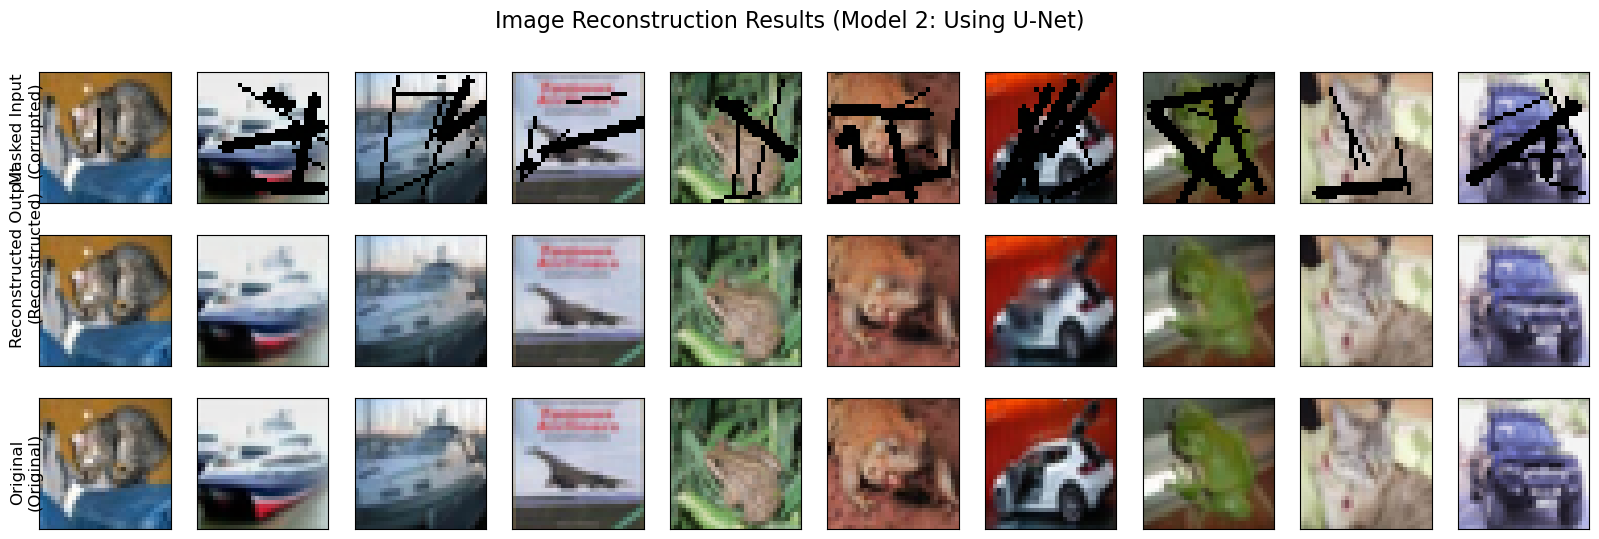

In [46]:
print("开始评估 U-Net 模型并显示修复结果...")
model_unet.eval()

with torch.no_grad():
    data_iter = iter(Testloader)
    masked_test_imgs, _, original_test_imgs = next(data_iter)
    
    reconstructed_imgs = model_unet(masked_test_imgs.to(device))
    
    masked_test_imgs = masked_test_imgs.cpu()
    reconstructed_imgs = reconstructed_imgs.cpu()
    original_test_imgs = original_test_imgs.cpu()

    n = 10
    plt.figure(figsize=(20, 6))
    plt.suptitle("Image Reconstruction Results (Model 2: Using U-Net)", fontsize=16)

    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(np.transpose(masked_test_imgs[i].numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Masked Input\n(Corrupted)", rotation=90, x=-0.1, y=0.1)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(np.transpose(reconstructed_imgs[i].numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Reconstructed Output\n(Reconstructed)", rotation=90, x=-0.1, y=0.1)
            
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(np.transpose(original_test_imgs[i].numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original\n(Original)", rotation=90, x=-0.1, y=0.1)

    plt.show()


This result is much more satisfying. And compared with simple AE, the generating images are much more clear and have more relience to masks.